In [1]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator, DataGenerator_LSTM_one_output
import tensorflow as tf
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
# import geopandas as gpd
from sklearn.neighbors import KDTree
from anndata import read_h5ad
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import umap

In [2]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional, Union
from anndata import AnnData


def BB_plot_grey(
    adata: AnnData,
    library_id: str = None,
    name: str = None,
    data_alpha: float = 0.8,
    tissue_alpha: float = 1.0,
    cmap: str = "Spectral_r",
    spot_size: tuple = (5, 30),
    ob1: str = None,
    ob2: str = None,
    ob3: str = None,
    col: int = None,
    show_color_bar: bool = True,
    show_size_legend: bool = True,
    show_axis: bool = False,
    cropped: bool = True,
    margin: int = 100,
    dpi: int = 150,
    output: str = None,
) -> Optional[AnnData]:
    
    ob_3 = adata.obsm[ob3][:,col]
    adata_ = adata[ob_3>0].copy()
    adata_0 = adata[ob_3<=0].copy()
    imagecol = adata_.obs["imagecol"]
    imagerow = adata_.obs["imagerow"]
    from sklearn.preprocessing import MinMaxScaler
    
    ob_1 = adata_.obsm[ob1][:,col]
    scaler = MinMaxScaler(feature_range=spot_size)
    ob1_size = scaler.fit_transform(ob_1.reshape(-1, 1))
    ob_2 = adata_.obsm[ob2][:,col]
#     print(ob_1)
#     print(ob_2)
    # plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()

    vmin = min(ob_2)
    vmax = max(ob_2)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(
        adata_.obs["imagecol"],
        adata_.obs["imagerow"],
        edgecolor="none",
        alpha=data_alpha,
        s=ob1_size,
        marker="o",
        vmin=vmin,
        vmax=vmax,
        cmap=plt.get_cmap(cmap),
        c=ob_2,
    )

    if show_color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(a,
                   width="100%",
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.0, 0.73, 0.05, 0.35),
                   bbox_transform=a.transAxes,
                   borderpad=4.3,
                   )
        cb = plt.colorbar(plot, cax=axins)
        cb.ax.set_xlabel(ob2, fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.20)
        cb.outline.set_visible(False)

    if show_size_legend:
        size_min, size_max = spot_size
        markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
                   size_min + 2 / 3 * (size_max - size_min), size_max]
        legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
        labels = ["{:.2f}".format(float((scaler.inverse_transform(np.array(i).reshape(1, 1)))))
                  for i in markers]
        a.legend(handles=legend_markers, labels=labels, loc='lower left', bbox_to_anchor=(1, 0.05),
                   scatterpoints=1, frameon=False, title=ob1)

    if not show_axis:
        a.axis("off")
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]
    if len(adata_0) > 0:
        a.scatter(
            adata_0.obs["imagecol"],
            adata_0.obs["imagerow"],
            edgecolor="none",
            alpha=data_alpha,
            s=5,
            marker="o",
            color="white",
        )
    
    # Overlay the tissue image
    a.imshow(
        image,
        alpha=tissue_alpha,
        zorder=-1,
    )

    if cropped:
        a.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])
        # plt.gca().invert_yaxis()

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    plt.show()




In [4]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [5]:

DATA_PATH = Path("/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium")

OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/Peter")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

In [7]:
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(lambda x:x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium/",
                                               "/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium/"))

In [8]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
gene_list

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [9]:
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["1142243F", "1160920F"]).unique())]

In [10]:
n_genes = len(gene_list)
training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "1142243F"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [11]:
train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [14]:
K.clear_session()
model = CNN_NB_multiple_genes((299, 299, 3), n_genes, cnnbase="resnet50", ft=False)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=False)

In [15]:
# model.load_weights("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/pretrained_model/CNN_NB_9visium_14_markers.h5")

In [16]:
train_history = model.fit(train_gen_,
                          epochs=200,
                          validation_data=valid_gen_,
                          callbacks=[callback]
                          )

Epoch 1/200
249/249 [==============================] - 950s 4s/step - loss: 40.3134 - gene_0_loss: 2.7117 - gene_1_loss: 1.4854 - gene_2_loss: 4.4911 - gene_3_loss: 2.7145 - gene_4_loss: 6.6813 - gene_5_loss: 2.4001 - gene_6_loss: 1.5094 - gene_7_loss: 3.6582 - gene_8_loss: 2.4574 - gene_9_loss: 2.1238 - gene_10_loss: 2.6262 - gene_11_loss: 2.1790 - gene_12_loss: 2.7833 - gene_13_loss: 2.4921 - val_loss: 32.2508 - val_gene_0_loss: 2.3734 - val_gene_1_loss: 1.3482 - val_gene_2_loss: 2.9957 - val_gene_3_loss: 2.1339 - val_gene_4_loss: 4.4936 - val_gene_5_loss: 2.0901 - val_gene_6_loss: 1.4145 - val_gene_7_loss: 2.5838 - val_gene_8_loss: 1.9367 - val_gene_9_loss: 2.0101 - val_gene_10_loss: 2.2264 - val_gene_11_loss: 2.0411 - val_gene_12_loss: 2.4134 - val_gene_13_loss: 2.1900
Epoch 2/200
249/249 [==============================] - 91s 365ms/step - loss: 30.8540 - gene_0_loss: 2.3343 - gene_1_loss: 1.3230 - gene_2_loss: 2.7264 - gene_3_loss: 2.0800 - gene_4_loss: 3.9325 - gene_5_loss: 2.040

249/249 [==============================] - 91s 367ms/step - loss: 21.9617 - gene_0_loss: 1.8354 - gene_1_loss: 0.9298 - gene_2_loss: 1.7209 - gene_3_loss: 1.5980 - gene_4_loss: 1.7396 - gene_5_loss: 1.4559 - gene_6_loss: 1.1686 - gene_7_loss: 1.8874 - gene_8_loss: 1.4635 - gene_9_loss: 1.6247 - gene_10_loss: 1.7505 - gene_11_loss: 1.5737 - gene_12_loss: 1.6748 - gene_13_loss: 1.5389 - val_loss: 21.9970 - val_gene_0_loss: 1.8424 - val_gene_1_loss: 0.9231 - val_gene_2_loss: 1.7170 - val_gene_3_loss: 1.5973 - val_gene_4_loss: 1.7348 - val_gene_5_loss: 1.4746 - val_gene_6_loss: 1.1687 - val_gene_7_loss: 1.8811 - val_gene_8_loss: 1.4675 - val_gene_9_loss: 1.6301 - val_gene_10_loss: 1.7527 - val_gene_11_loss: 1.5830 - val_gene_12_loss: 1.6778 - val_gene_13_loss: 1.5470
Epoch 22/200
249/249 [==============================] - 91s 368ms/step - loss: 21.8744 - gene_0_loss: 1.8282 - gene_1_loss: 0.9275 - gene_2_loss: 1.7112 - gene_3_loss: 1.5917 - gene_4_loss: 1.7286 - gene_5_loss: 1.4491 - gene_

249/249 [==============================] - 91s 367ms/step - loss: 20.9261 - gene_0_loss: 1.7492 - gene_1_loss: 0.9022 - gene_2_loss: 1.6103 - gene_3_loss: 1.5226 - gene_4_loss: 1.6128 - gene_5_loss: 1.3756 - gene_6_loss: 1.1426 - gene_7_loss: 1.7745 - gene_8_loss: 1.3996 - gene_9_loss: 1.5715 - gene_10_loss: 1.6713 - gene_11_loss: 1.5203 - gene_12_loss: 1.5981 - gene_13_loss: 1.4754 - val_loss: 21.0351 - val_gene_0_loss: 1.7615 - val_gene_1_loss: 0.8988 - val_gene_2_loss: 1.6157 - val_gene_3_loss: 1.5259 - val_gene_4_loss: 1.6143 - val_gene_5_loss: 1.4037 - val_gene_6_loss: 1.1454 - val_gene_7_loss: 1.7742 - val_gene_8_loss: 1.4094 - val_gene_9_loss: 1.5813 - val_gene_10_loss: 1.6788 - val_gene_11_loss: 1.5330 - val_gene_12_loss: 1.6066 - val_gene_13_loss: 1.4866
Epoch 42/200
249/249 [==============================] - 91s 367ms/step - loss: 20.8977 - gene_0_loss: 1.7468 - gene_1_loss: 0.9014 - gene_2_loss: 1.6074 - gene_3_loss: 1.5206 - gene_4_loss: 1.6096 - gene_5_loss: 1.3734 - gene_

249/249 [==============================] - 91s 367ms/step - loss: 20.5340 - gene_0_loss: 1.7153 - gene_1_loss: 0.8904 - gene_2_loss: 1.5718 - gene_3_loss: 1.4953 - gene_4_loss: 1.5710 - gene_5_loss: 1.3429 - gene_6_loss: 1.1311 - gene_7_loss: 1.7332 - gene_8_loss: 1.3744 - gene_9_loss: 1.5489 - gene_10_loss: 1.6403 - gene_11_loss: 1.4991 - gene_12_loss: 1.5691 - gene_13_loss: 1.4514 - val_loss: 20.6821 - val_gene_0_loss: 1.7303 - val_gene_1_loss: 0.8888 - val_gene_2_loss: 1.5813 - val_gene_3_loss: 1.5008 - val_gene_4_loss: 1.5752 - val_gene_5_loss: 1.3753 - val_gene_6_loss: 1.1358 - val_gene_7_loss: 1.7356 - val_gene_8_loss: 1.3877 - val_gene_9_loss: 1.5612 - val_gene_10_loss: 1.6508 - val_gene_11_loss: 1.5137 - val_gene_12_loss: 1.5806 - val_gene_13_loss: 1.4651
Epoch 62/200
249/249 [==============================] - 91s 367ms/step - loss: 20.5210 - gene_0_loss: 1.7141 - gene_1_loss: 0.8900 - gene_2_loss: 1.5706 - gene_3_loss: 1.4944 - gene_4_loss: 1.5698 - gene_5_loss: 1.3417 - gene_

249/249 [==============================] - 91s 367ms/step - loss: 20.3324 - gene_0_loss: 1.6969 - gene_1_loss: 0.8833 - gene_2_loss: 1.5539 - gene_3_loss: 1.4821 - gene_4_loss: 1.5525 - gene_5_loss: 1.3242 - gene_6_loss: 1.1241 - gene_7_loss: 1.7134 - gene_8_loss: 1.3608 - gene_9_loss: 1.5360 - gene_10_loss: 1.6244 - gene_11_loss: 1.4876 - gene_12_loss: 1.5541 - gene_13_loss: 1.4390 - val_loss: 20.5081 - val_gene_0_loss: 1.7141 - val_gene_1_loss: 0.8831 - val_gene_2_loss: 1.5660 - val_gene_3_loss: 1.4891 - val_gene_4_loss: 1.5584 - val_gene_5_loss: 1.3592 - val_gene_6_loss: 1.1304 - val_gene_7_loss: 1.7176 - val_gene_8_loss: 1.3766 - val_gene_9_loss: 1.5503 - val_gene_10_loss: 1.6370 - val_gene_11_loss: 1.5037 - val_gene_12_loss: 1.5677 - val_gene_13_loss: 1.4549
Epoch 82/200
249/249 [==============================] - 91s 367ms/step - loss: 20.3247 - gene_0_loss: 1.6962 - gene_1_loss: 0.8831 - gene_2_loss: 1.5532 - gene_3_loss: 1.4816 - gene_4_loss: 1.5519 - gene_5_loss: 1.3235 - gene_

249/249 [==============================] - 92s 368ms/step - loss: 20.2050 - gene_0_loss: 1.6850 - gene_1_loss: 0.8784 - gene_2_loss: 1.5434 - gene_3_loss: 1.4741 - gene_4_loss: 1.5420 - gene_5_loss: 1.3116 - gene_6_loss: 1.1191 - gene_7_loss: 1.7017 - gene_8_loss: 1.3520 - gene_9_loss: 1.5273 - gene_10_loss: 1.6145 - gene_11_loss: 1.4802 - gene_12_loss: 1.5445 - gene_13_loss: 1.4313 - val_loss: 20.4025 - val_gene_0_loss: 1.7039 - val_gene_1_loss: 0.8794 - val_gene_2_loss: 1.5573 - val_gene_3_loss: 1.4824 - val_gene_4_loss: 1.5492 - val_gene_5_loss: 1.3483 - val_gene_6_loss: 1.1270 - val_gene_7_loss: 1.7074 - val_gene_8_loss: 1.3697 - val_gene_9_loss: 1.5433 - val_gene_10_loss: 1.6287 - val_gene_11_loss: 1.4974 - val_gene_12_loss: 1.5597 - val_gene_13_loss: 1.4489
Epoch 102/200
249/249 [==============================] - 91s 367ms/step - loss: 20.1998 - gene_0_loss: 1.6845 - gene_1_loss: 0.8781 - gene_2_loss: 1.5429 - gene_3_loss: 1.4738 - gene_4_loss: 1.5415 - gene_5_loss: 1.3111 - gene

249/249 [==============================] - 91s 367ms/step - loss: 20.1146 - gene_0_loss: 1.6764 - gene_1_loss: 0.8746 - gene_2_loss: 1.5362 - gene_3_loss: 1.4686 - gene_4_loss: 1.5349 - gene_5_loss: 1.3023 - gene_6_loss: 1.1154 - gene_7_loss: 1.6939 - gene_8_loss: 1.3457 - gene_9_loss: 1.5209 - gene_10_loss: 1.6075 - gene_11_loss: 1.4748 - gene_12_loss: 1.5376 - gene_13_loss: 1.4258 - val_loss: 20.3306 - val_gene_0_loss: 1.6969 - val_gene_1_loss: 0.8769 - val_gene_2_loss: 1.5516 - val_gene_3_loss: 1.4779 - val_gene_4_loss: 1.5432 - val_gene_5_loss: 1.3404 - val_gene_6_loss: 1.1247 - val_gene_7_loss: 1.7007 - val_gene_8_loss: 1.3649 - val_gene_9_loss: 1.5383 - val_gene_10_loss: 1.6232 - val_gene_11_loss: 1.4930 - val_gene_12_loss: 1.5541 - val_gene_13_loss: 1.4448
Epoch 122/200
249/249 [==============================] - 91s 368ms/step - loss: 20.1107 - gene_0_loss: 1.6760 - gene_1_loss: 0.8744 - gene_2_loss: 1.5359 - gene_3_loss: 1.4684 - gene_4_loss: 1.5346 - gene_5_loss: 1.3019 - gene

249/249 [==============================] - 91s 367ms/step - loss: 20.0457 - gene_0_loss: 1.6698 - gene_1_loss: 0.8715 - gene_2_loss: 1.5310 - gene_3_loss: 1.4645 - gene_4_loss: 1.5298 - gene_5_loss: 1.2950 - gene_6_loss: 1.1123 - gene_7_loss: 1.6882 - gene_8_loss: 1.3407 - gene_9_loss: 1.5159 - gene_10_loss: 1.6023 - gene_11_loss: 1.4707 - gene_12_loss: 1.5324 - gene_13_loss: 1.4216 - val_loss: 20.2780 - val_gene_0_loss: 1.6918 - val_gene_1_loss: 0.8751 - val_gene_2_loss: 1.5475 - val_gene_3_loss: 1.4747 - val_gene_4_loss: 1.5390 - val_gene_5_loss: 1.3343 - val_gene_6_loss: 1.1229 - val_gene_7_loss: 1.6960 - val_gene_8_loss: 1.3614 - val_gene_9_loss: 1.5346 - val_gene_10_loss: 1.6191 - val_gene_11_loss: 1.4897 - val_gene_12_loss: 1.5500 - val_gene_13_loss: 1.4418
Epoch 142/200
249/249 [==============================] - 91s 367ms/step - loss: 20.0427 - gene_0_loss: 1.6695 - gene_1_loss: 0.8714 - gene_2_loss: 1.5307 - gene_3_loss: 1.4644 - gene_4_loss: 1.5296 - gene_5_loss: 1.2947 - gene

249/249 [==============================] - 91s 368ms/step - loss: 19.9909 - gene_0_loss: 1.6646 - gene_1_loss: 0.8689 - gene_2_loss: 1.5269 - gene_3_loss: 1.4613 - gene_4_loss: 1.5258 - gene_5_loss: 1.2892 - gene_6_loss: 1.1098 - gene_7_loss: 1.6839 - gene_8_loss: 1.3368 - gene_9_loss: 1.5118 - gene_10_loss: 1.5982 - gene_11_loss: 1.4674 - gene_12_loss: 1.5281 - gene_13_loss: 1.4182 - val_loss: 20.2379 - val_gene_0_loss: 1.6879 - val_gene_1_loss: 0.8737 - val_gene_2_loss: 1.5444 - val_gene_3_loss: 1.4723 - val_gene_4_loss: 1.5359 - val_gene_5_loss: 1.3294 - val_gene_6_loss: 1.1216 - val_gene_7_loss: 1.6925 - val_gene_8_loss: 1.3587 - val_gene_9_loss: 1.5317 - val_gene_10_loss: 1.6161 - val_gene_11_loss: 1.4871 - val_gene_12_loss: 1.5469 - val_gene_13_loss: 1.4396
Epoch 162/200
249/249 [==============================] - 91s 367ms/step - loss: 19.9884 - gene_0_loss: 1.6643 - gene_1_loss: 0.8688 - gene_2_loss: 1.5267 - gene_3_loss: 1.4612 - gene_4_loss: 1.5257 - gene_5_loss: 1.2889 - gene

249/249 [==============================] - 91s 367ms/step - loss: 19.9457 - gene_0_loss: 1.6602 - gene_1_loss: 0.8667 - gene_2_loss: 1.5235 - gene_3_loss: 1.4587 - gene_4_loss: 1.5227 - gene_5_loss: 1.2843 - gene_6_loss: 1.1076 - gene_7_loss: 1.6804 - gene_8_loss: 1.3335 - gene_9_loss: 1.5085 - gene_10_loss: 1.5948 - gene_11_loss: 1.4647 - gene_12_loss: 1.5246 - gene_13_loss: 1.4155 - val_loss: 20.2064 - val_gene_0_loss: 1.6847 - val_gene_1_loss: 0.8727 - val_gene_2_loss: 1.5420 - val_gene_3_loss: 1.4705 - val_gene_4_loss: 1.5335 - val_gene_5_loss: 1.3255 - val_gene_6_loss: 1.1206 - val_gene_7_loss: 1.6898 - val_gene_8_loss: 1.3566 - val_gene_9_loss: 1.5295 - val_gene_10_loss: 1.6138 - val_gene_11_loss: 1.4851 - val_gene_12_loss: 1.5443 - val_gene_13_loss: 1.4378
Epoch 182/200
249/249 [==============================] - 91s 367ms/step - loss: 19.9436 - gene_0_loss: 1.6601 - gene_1_loss: 0.8666 - gene_2_loss: 1.5234 - gene_3_loss: 1.4585 - gene_4_loss: 1.5225 - gene_5_loss: 1.2841 - gene

In [17]:
model.save(OUT_PATH / "CNN_NB_9visium_14_markers_v2.h5")

In [14]:
latent_layer = Model(inputs=model.input, outputs=model.get_layer("global_average_pooling2d").output)

In [26]:
test_predictions = model.predict(test_gen__1)
test_dataset_1.obsm["latent_features"] = latent_layer.predict(test_gen__1)
from scipy.stats import nbinom
y_preds = []
y_preds_sampling = []
y_stds = []
y_intervals_low = []
y_intervals_high = []
n_list=[]
p_list=[]
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    
    y_pred = nbinom.mean(n, p)
    y_pred_sampling = np.array([nbinom.rvs(n[i],p[i], size=1000).mean() for i in range(n.shape[0])])
    y_preds.append(y_pred)
    y_preds_sampling.append(y_pred_sampling)
    
    y_std = nbinom.std(n, p)
    y_stds.append(y_std)
    y_interval_low, y_interval_high = nbinom.interval(0.80,n, p)
    y_intervals_low.append(y_interval_low)
    y_intervals_high.append(y_interval_high)
    n_list.append(n)
    p_list.append(p)
test_dataset_1.obsm["n"] = np.array(n_list).transpose()
test_dataset_1.obsm["p"] = np.array(p_list).transpose()
test_dataset_1.obsm["predicted_gene"] = np.array(y_preds).transpose()
test_dataset_1.obsm["predicted_gene_sampling"] = np.array(y_preds_sampling).transpose()
test_dataset_1.obsm["predicted_gene_std"] = np.array(y_stds).transpose()
test_dataset_1.obsm["predicted_gene_interval_low"] = np.array(y_intervals_low).transpose()
test_dataset_1.obsm["predicted_gene_interval_high"] = np.array(y_intervals_high).transpose()

In [29]:
test_dataset_1.obsm["predicted_gene"].reshape(-1,)

array([2.2179029 , 0.4082379 , 5.36780596, ..., 1.47770226, 1.90173149,
       1.19390285])

In [31]:
import seaborn as sns
sns.set_theme(style="ticks")

In [33]:
df = pd.DataFrame({
    "predicted_gene_mean_dist": test_dataset_1.obsm["predicted_gene"].reshape(-1,),
    "predicted_gene_mean_sampling" : test_dataset_1.obsm["predicted_gene_sampling"].reshape(-1,)
})

In [36]:
df

,predicted_gene_mean_dist,predicted_gene_mean_sampling
0,2.217903,2.209
1,0.408238,0.400
2,5.367806,5.240
3,2.121524,1.990
4,2.412158,2.448
...,...,...
32727,2.852089,2.846
32728,2.797189,2.869
32729,1.477702,1.474
32730,1.901731,1.912


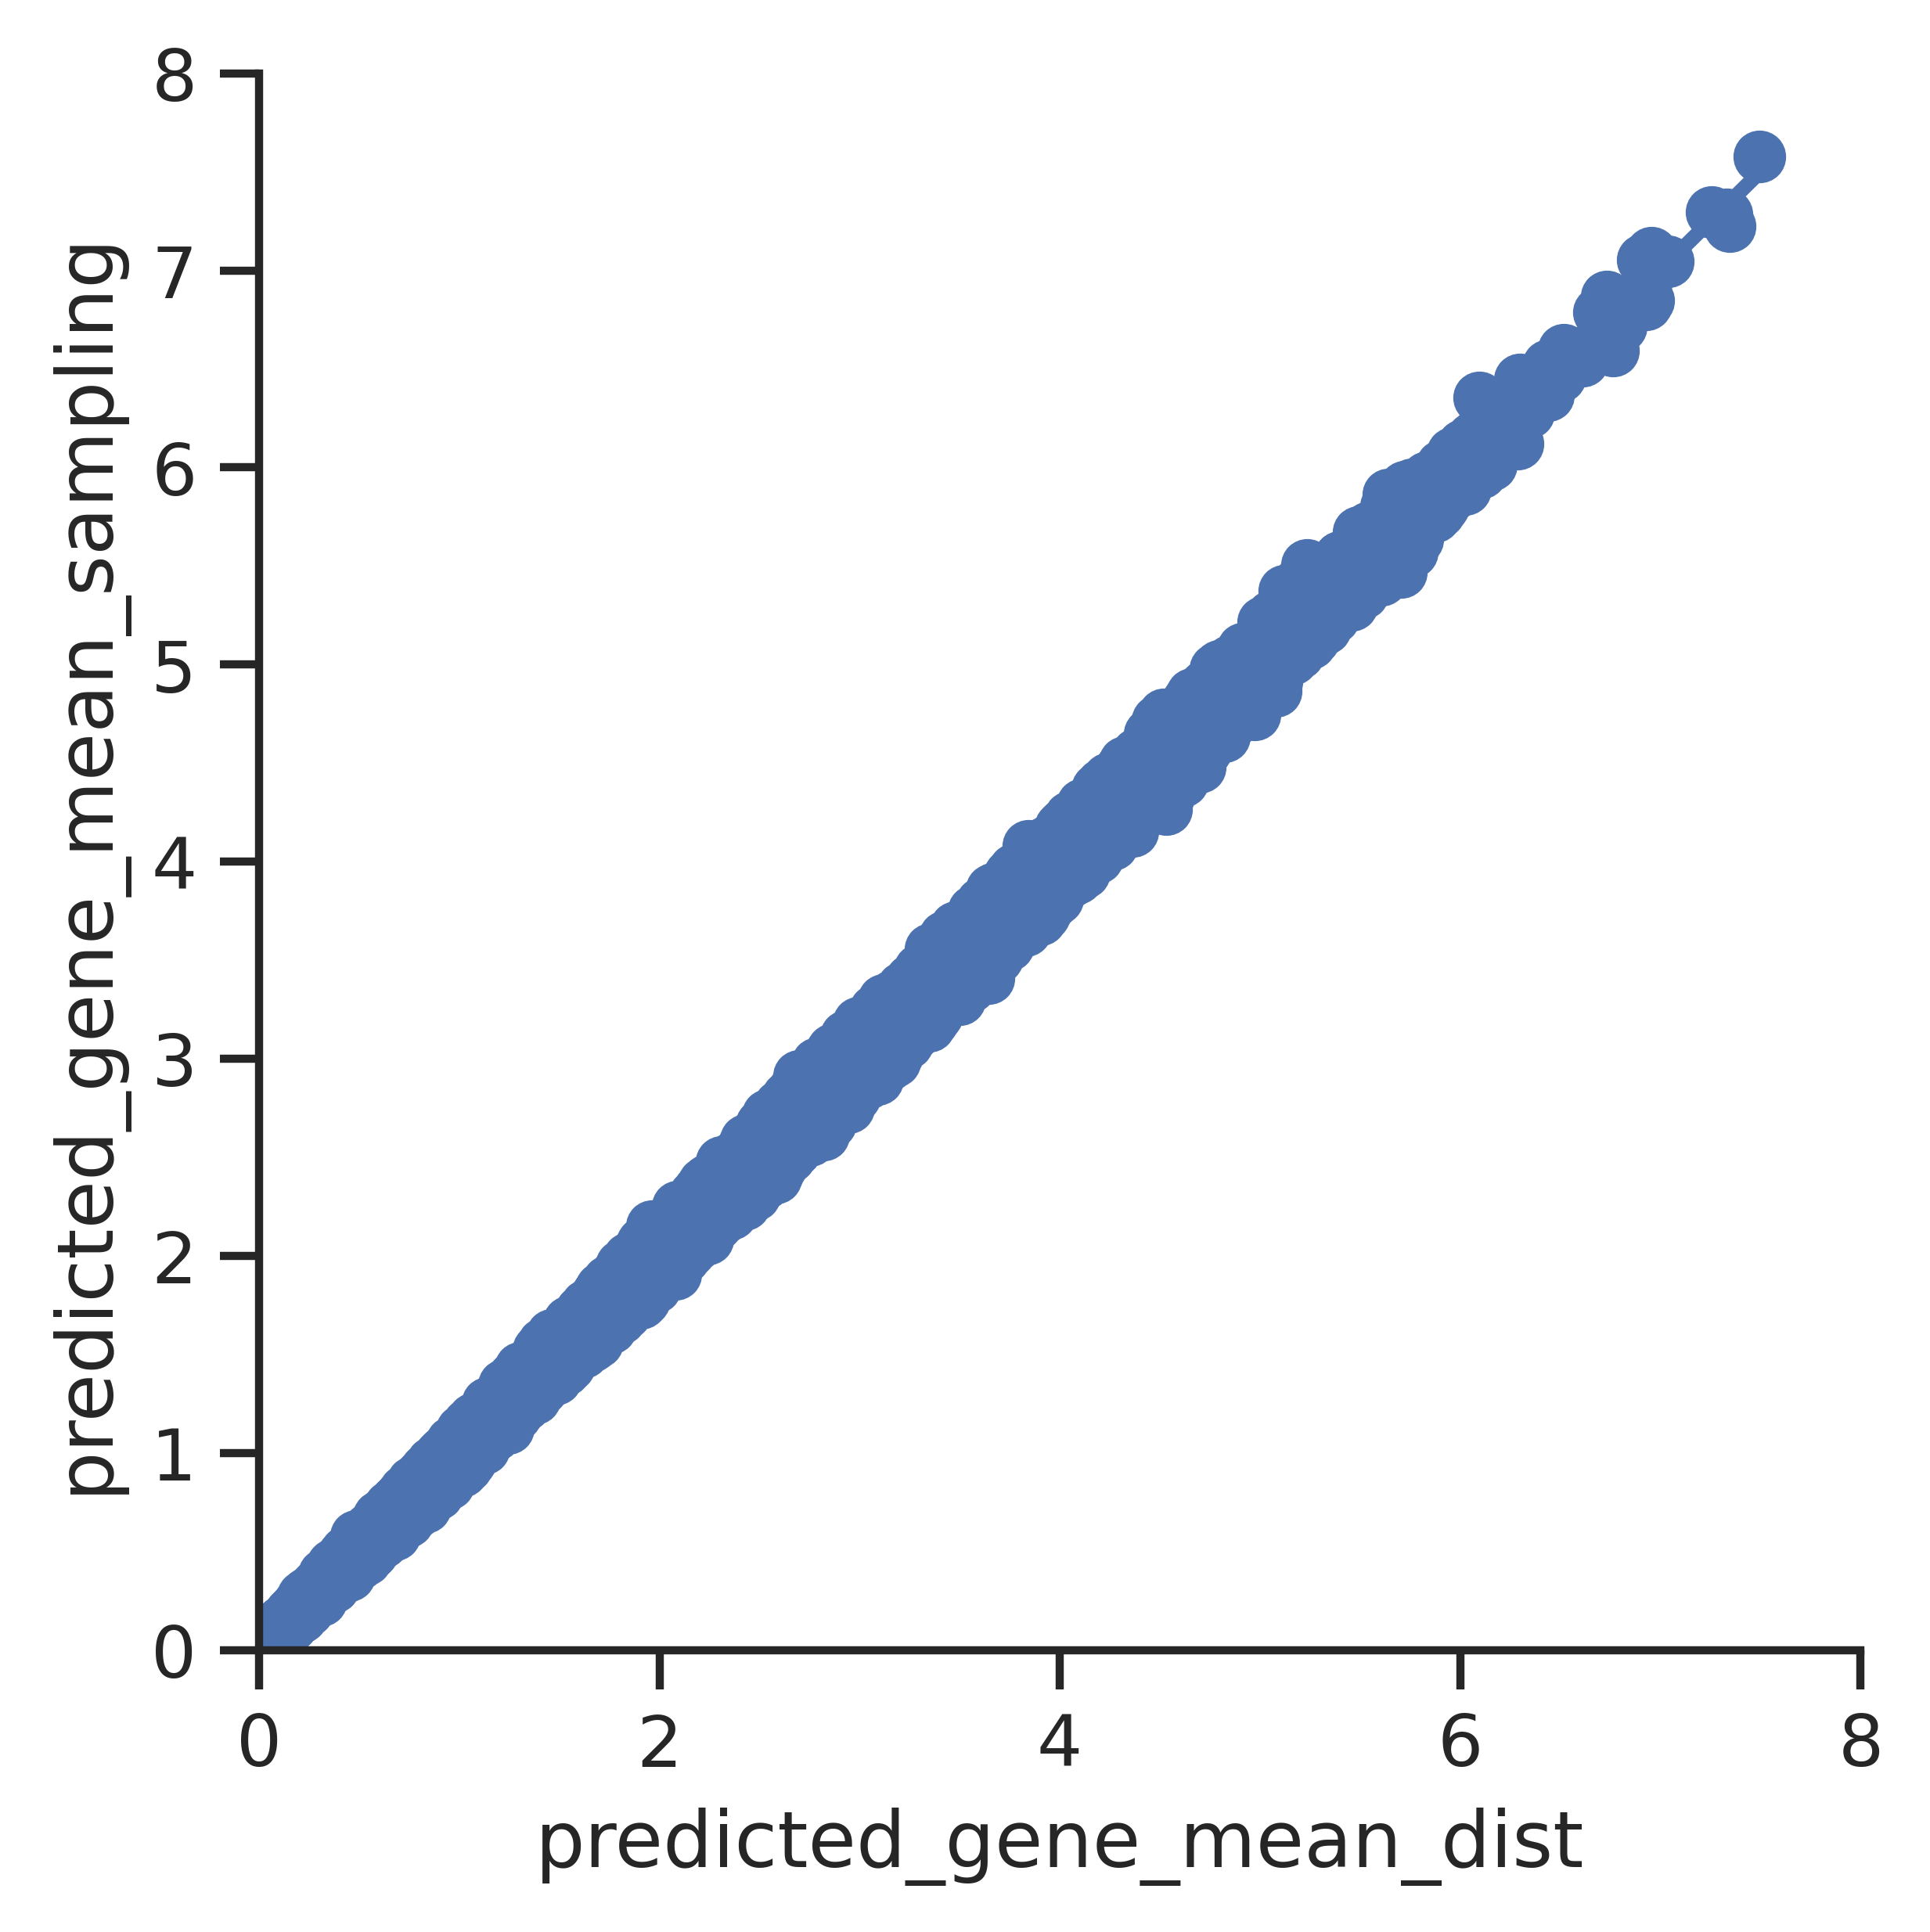

In [39]:
g = sns.lmplot(
    data=df,
    x="predicted_gene_mean_dist",
    y="predicted_gene_mean_sampling",
    palette="muted", ci=None, 
    height=4, scatter_kws={"s": 50, "alpha": 1}
    
)
g.set(xlim=(0, 8))
g.set(ylim=(0, 8))

In [41]:
test_predictions = model.predict(test_gen__2)
test_dataset_2.obsm["latent_features"] = latent_layer.predict(test_gen__2)
from scipy.stats import nbinom
y_preds = []
y_preds_sampling = []
y_stds = []
y_intervals_low = []
y_intervals_high = []
n_list=[]
p_list=[]
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    
    y_pred = nbinom.mean(n, p)
    y_pred_sampling = np.array([nbinom.rvs(n[i],p[i], size=1000).mean() for i in range(n.shape[0])])
    y_preds.append(y_pred)
    y_preds_sampling.append(y_pred_sampling)
    
    y_std = nbinom.std(n, p)
    y_stds.append(y_std)
    y_interval_low, y_interval_high = nbinom.interval(0.80,n, p)
    y_intervals_low.append(y_interval_low)
    y_intervals_high.append(y_interval_high)
    n_list.append(n)
    p_list.append(p)
test_dataset_2.obsm["n"] = np.array(n_list).transpose()
test_dataset_2.obsm["p"] = np.array(p_list).transpose()
test_dataset_2.obsm["predicted_gene"] = np.array(y_preds).transpose()
test_dataset_2.obsm["predicted_gene_sampling"] = np.array(y_preds_sampling).transpose()
test_dataset_2.obsm["predicted_gene_std"] = np.array(y_stds).transpose()
test_dataset_2.obsm["predicted_gene_interval_low"] = np.array(y_intervals_low).transpose()
test_dataset_2.obsm["predicted_gene_interval_high"] = np.array(y_intervals_high).transpose()

In [18]:
# OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/CNN_NB_std")

In [42]:
OUT_PATH = Path("/clusterdata/uqxtan9/Xiao/STimage/development/CNN_NB_std_v1")
OUT_PATH.mkdir(exist_ok=True, parents=True)

In [43]:
# chenge to 0 but no spots removed

df = pd.DataFrame()
k=0
for i in range(100):
    pred_adata_valid = test_dataset_1[:,gene_list].copy()
    pred_adata_valid.obsm["predicted_gene_interval_low_"] = pred_adata_valid.obsm["predicted_gene"] - k * pred_adata_valid.obsm["predicted_gene_std"]   
    pred_adata_valid.obsm["predicted_gene"][pred_adata_valid.obsm["predicted_gene_interval_low_"] <0] = 0
    pred_adata_valid.X = pred_adata_valid.obsm["predicted_gene"]
    gc_adata_valid = test_dataset_1[:,gene_list].copy()
    
    pred_adata_test = test_dataset_2[:,gene_list].copy()
    pred_adata_test.obsm["predicted_gene_interval_low_"] = pred_adata_test.obsm["predicted_gene"] - k * pred_adata_test.obsm["predicted_gene_std"]
    pred_adata_test.obsm["predicted_gene"][pred_adata_test.obsm["predicted_gene_interval_low_"] <0] = 0
    pred_adata_test.X = pred_adata_test.obsm["predicted_gene"]
    gc_adata_test = test_dataset_2[:,gene_list].copy()
    
    k = i / 20
    
    for j, gene in enumerate(pred_adata_valid.var_names):
        n_spots_to_keep_valid = sum(pred_adata_valid.obsm["predicted_gene_interval_low_"] >0)[j]
        n_spots_to_keep_test = sum(pred_adata_test.obsm["predicted_gene_interval_low_"] >0)[j]
        if n_spots_to_keep_valid > 2 and n_spots_to_keep_test > 2:
#             spots_to_keep_valid = pred_adata_valid.obsm["predicted_gene_interval_low_"][:,j]
#         pred_adata_valid_ = pred_adata_valid.copy()
#             pred_adata_valid.X[:,j][spots_to_keep_valid<0] = 0
#         gc_adata_valid_ = gc_adata_valid.copy()
            
#             spots_to_keep_test = pred_adata_test.obsm["predicted_gene_interval_low_"][:,j]
#             pred_adata_test_ = pred_adata_test.copy()
#             pred_adata_test.X[:,j][spots_to_keep_test<0] = 0
#         gc_adata_test_ = gc_adata_test.copy()
            
            
            cor_val = calculate_correlation(pred_adata_valid.to_df().loc[:,gene], gc_adata_valid.to_df().loc[:,gene])
            df = df.append(pd.Series([gene, cor_val, "FFPE", n_spots_to_keep_valid*100/ pred_adata_valid.n_obs, k], index=["Gene", "Pearson correlation", "Slide"," % Spots left", "k"]),
                  ignore_index=True)
        
            cor_val = calculate_correlation(pred_adata_test.to_df().loc[:,gene], gc_adata_test.to_df().loc[:,gene])
            df = df.append(pd.Series([gene, cor_val, "1160920F", n_spots_to_keep_test*100/ pred_adata_test.n_obs, k], index=["Gene", "Pearson correlation", "Slide"," % Spots left", "k"]),
                  ignore_index=True)

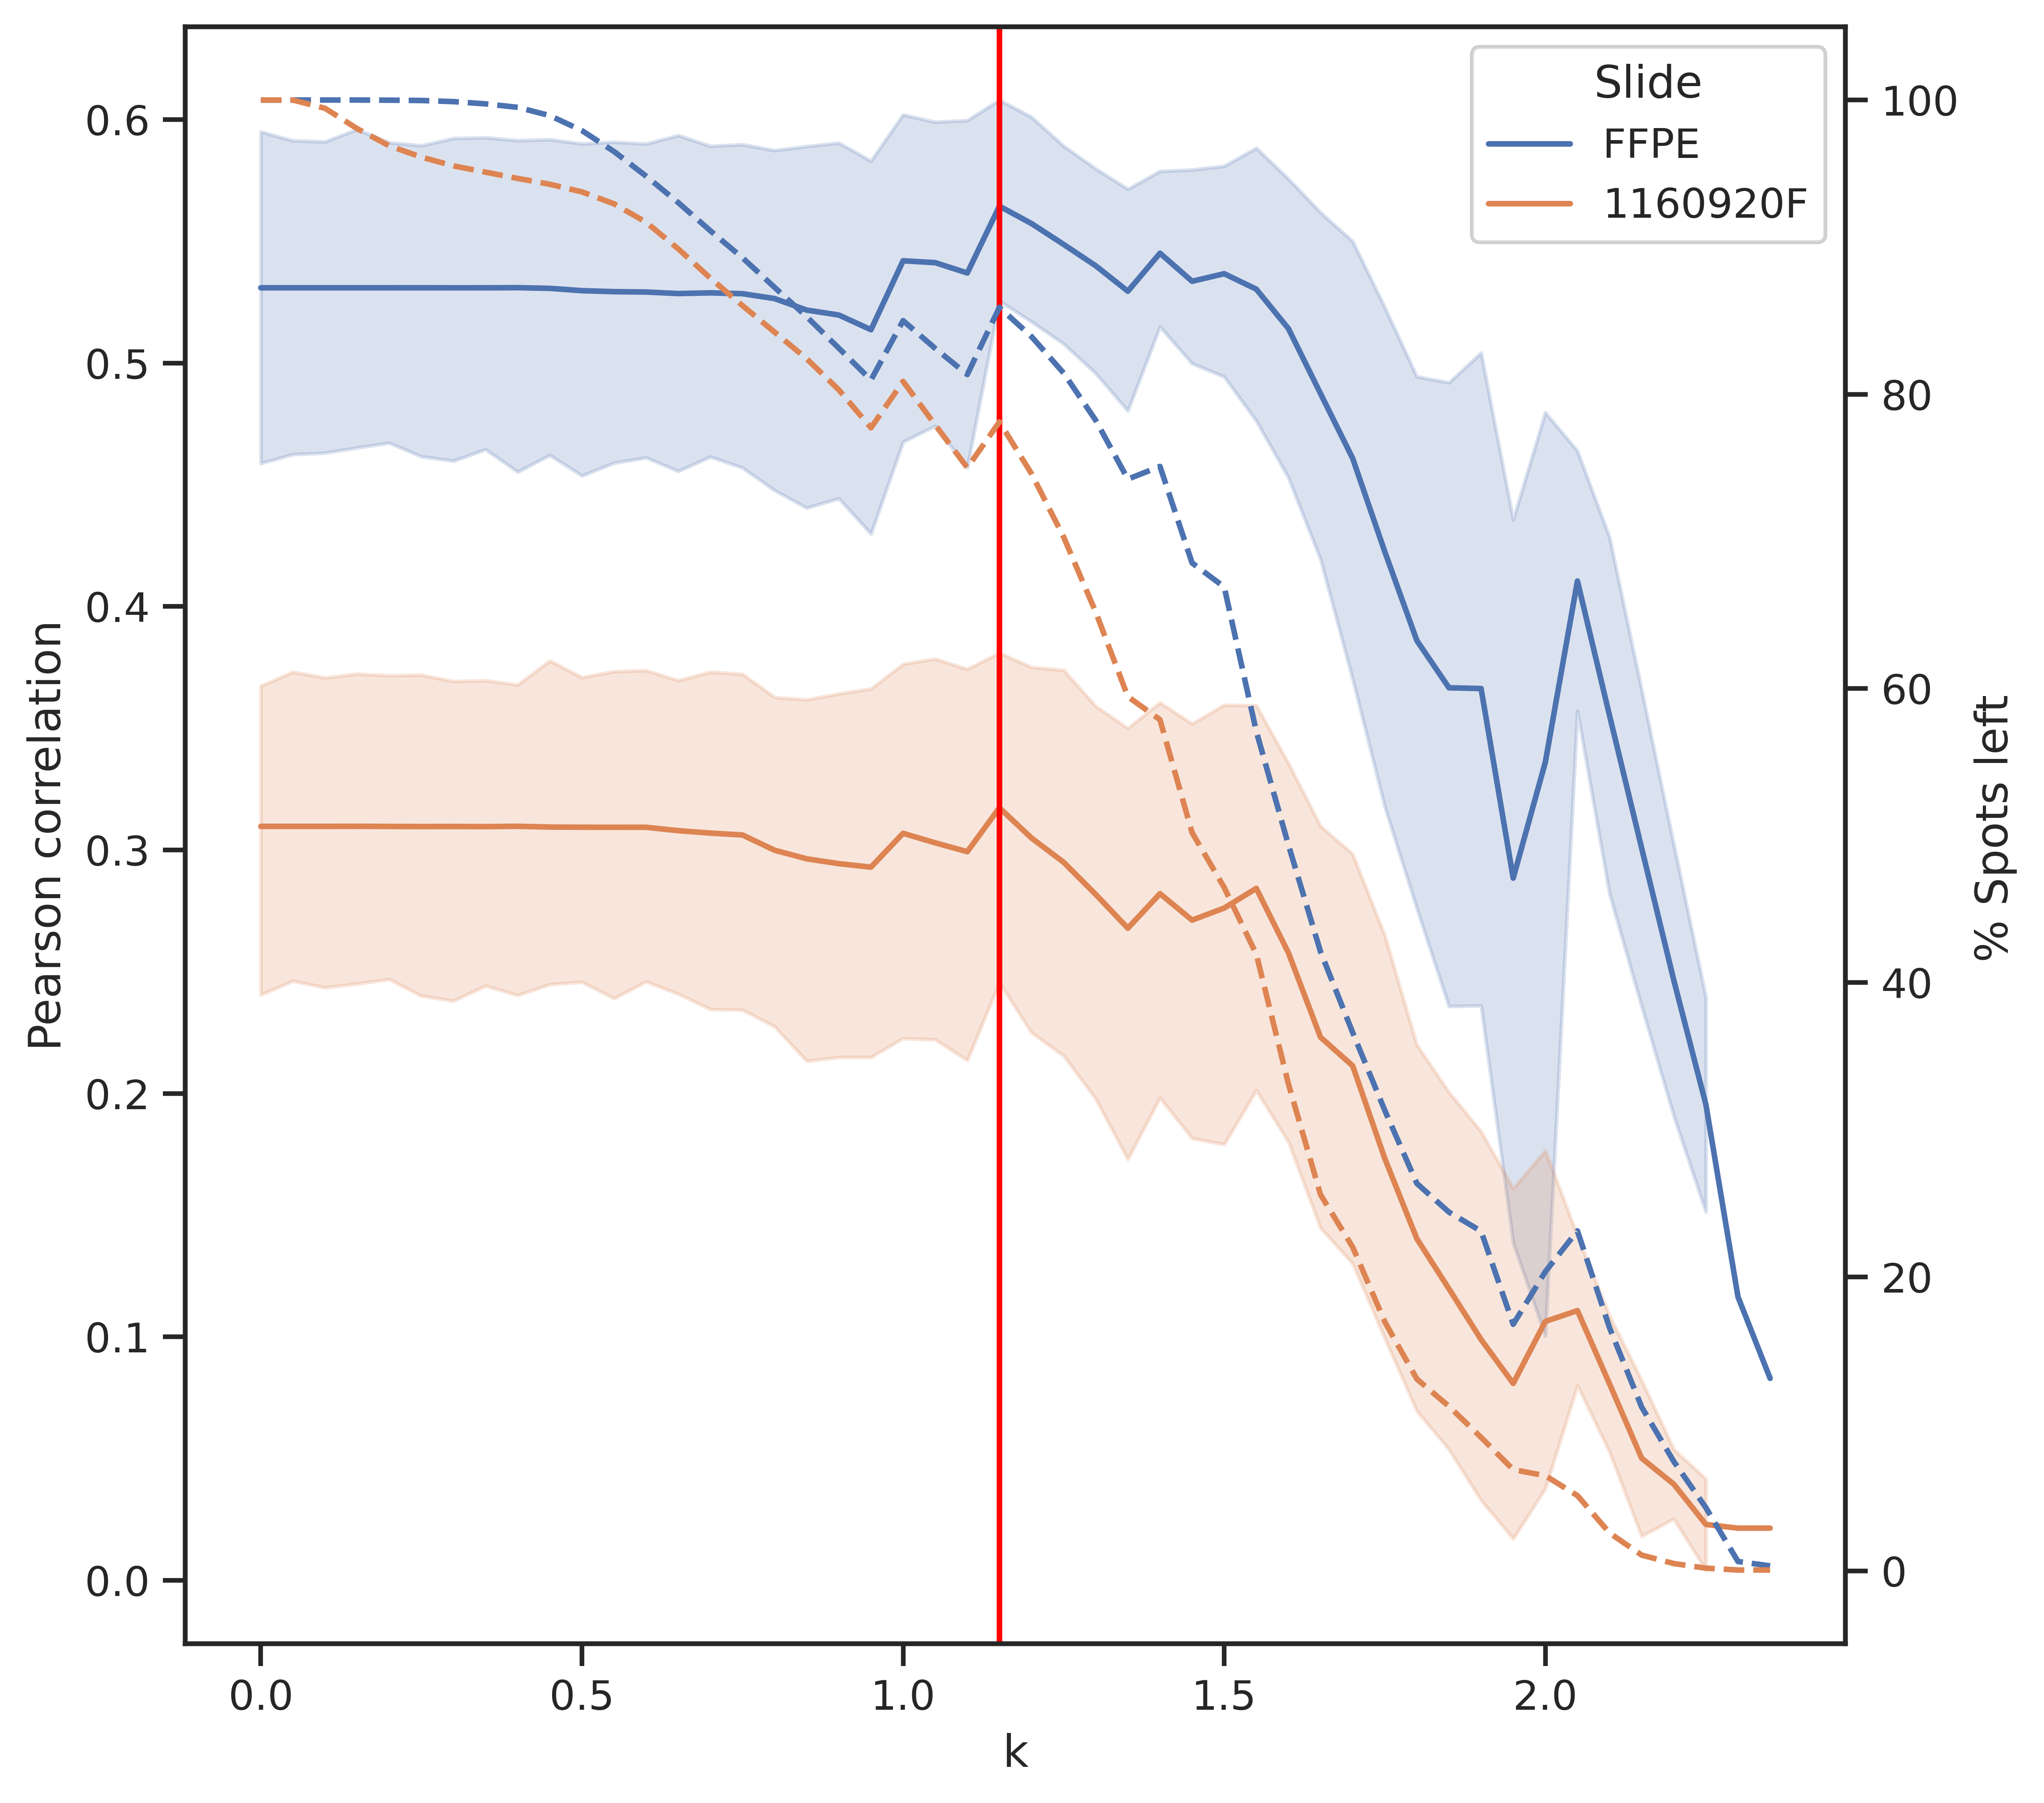

In [44]:
fig, ax1 = plt.subplots(figsize=(8,8))
sns.lineplot(data=df, x="k", y="Pearson correlation", hue="Slide",ax=ax1)
plt.axvline(1.15, 0,1.2,c="red")
ax2 = ax1.twinx()
sns.lineplot(data=df, x="k", y=" % Spots left", hue="Slide", linestyle='--', ax=ax2, ci=None)
plt.show()

In [45]:
df_k = df[df["k"]==1.15]

In [46]:
df_k_clean = df_k[df_k[" % Spots left"] >10]

In [47]:
df_k_clean["Uncertainty Filtering"] = "After"

<ipython-input-47-5d5c77ad07e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k_clean["Uncertainty Filtering"] = "After"


In [48]:
df_k_clean_ = df_k_clean[["Gene", "Pearson correlation", "Slide", "Uncertainty Filtering"]]

In [49]:
df_k_clean_

,Gene,Pearson correlation,Slide,Uncertainty Filtering
638,COX6C,0.465202,FFPE,After
639,COX6C,0.343157,1160920F,After
640,PABPC1,0.653862,FFPE,After
641,PABPC1,0.398518,1160920F,After
642,GNAS,0.535386,FFPE,After
643,GNAS,0.397046,1160920F,After
644,HSP90AB1,0.589590,FFPE,After
645,HSP90AB1,0.418384,1160920F,After
646,ATP1A1,0.662963,FFPE,After
647,ATP1A1,0.278423,1160920F,After


In [50]:
test_dataset_1_ = test_dataset_1[:,gene_list].copy()
test_dataset_1_.X = test_dataset_1_.obsm["predicted_gene"]

In [51]:
test_dataset_2_ = test_dataset_2[:,gene_list].copy()
test_dataset_2_.X = test_dataset_2_.obsm["predicted_gene"]

In [52]:
pred_adata = test_dataset_1_
test_dataset = test_dataset_1
df = pd.DataFrame()

for gene in pred_adata.var_names:
    cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, "FFPE"], index=["Gene", "Pearson correlation", "Slide"]),
                  ignore_index=True)

pred_adata = test_dataset_2_
test_dataset = test_dataset_2

for gene in pred_adata.var_names:
    cor_val = calculate_correlation(pred_adata.to_df().loc[:,gene], test_dataset.to_df().loc[:,gene])
    df = df.append(pd.Series([gene, cor_val, "1160920F"], index=["Gene", "Pearson correlation", "Slide"]),
                  ignore_index=True)

In [53]:
df["Uncertainty Filtering"] = "Before"

In [54]:
df = df.append(df_k_clean_, ignore_index=True)

In [55]:
df

,Gene,Pearson correlation,Slide,Uncertainty Filtering
0,COX6C,0.512666,FFPE,Before
1,TTLL12,0.294913,FFPE,Before
2,PABPC1,0.653862,FFPE,Before
3,GNAS,0.531569,FFPE,Before
4,HSP90AB1,0.612975,FFPE,Before
5,TFF3,0.249623,FFPE,Before
6,ATP1A1,0.685395,FFPE,Before
7,B2M,0.549984,FFPE,Before
8,FASN,0.492512,FFPE,Before
9,SPARC,0.505797,FFPE,Before


In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'axes.grid' : False})

In [57]:
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1160920F_Before vs. 1160920F_After: Mann-Whitney-Wilcoxon test two-sided, P_val:8.266e-01 U_stat=7.250e+01
FFPE_Before vs. FFPE_After: Mann-Whitney-Wilcoxon test two-sided, P_val:6.619e-01 U_stat=7.500e+01


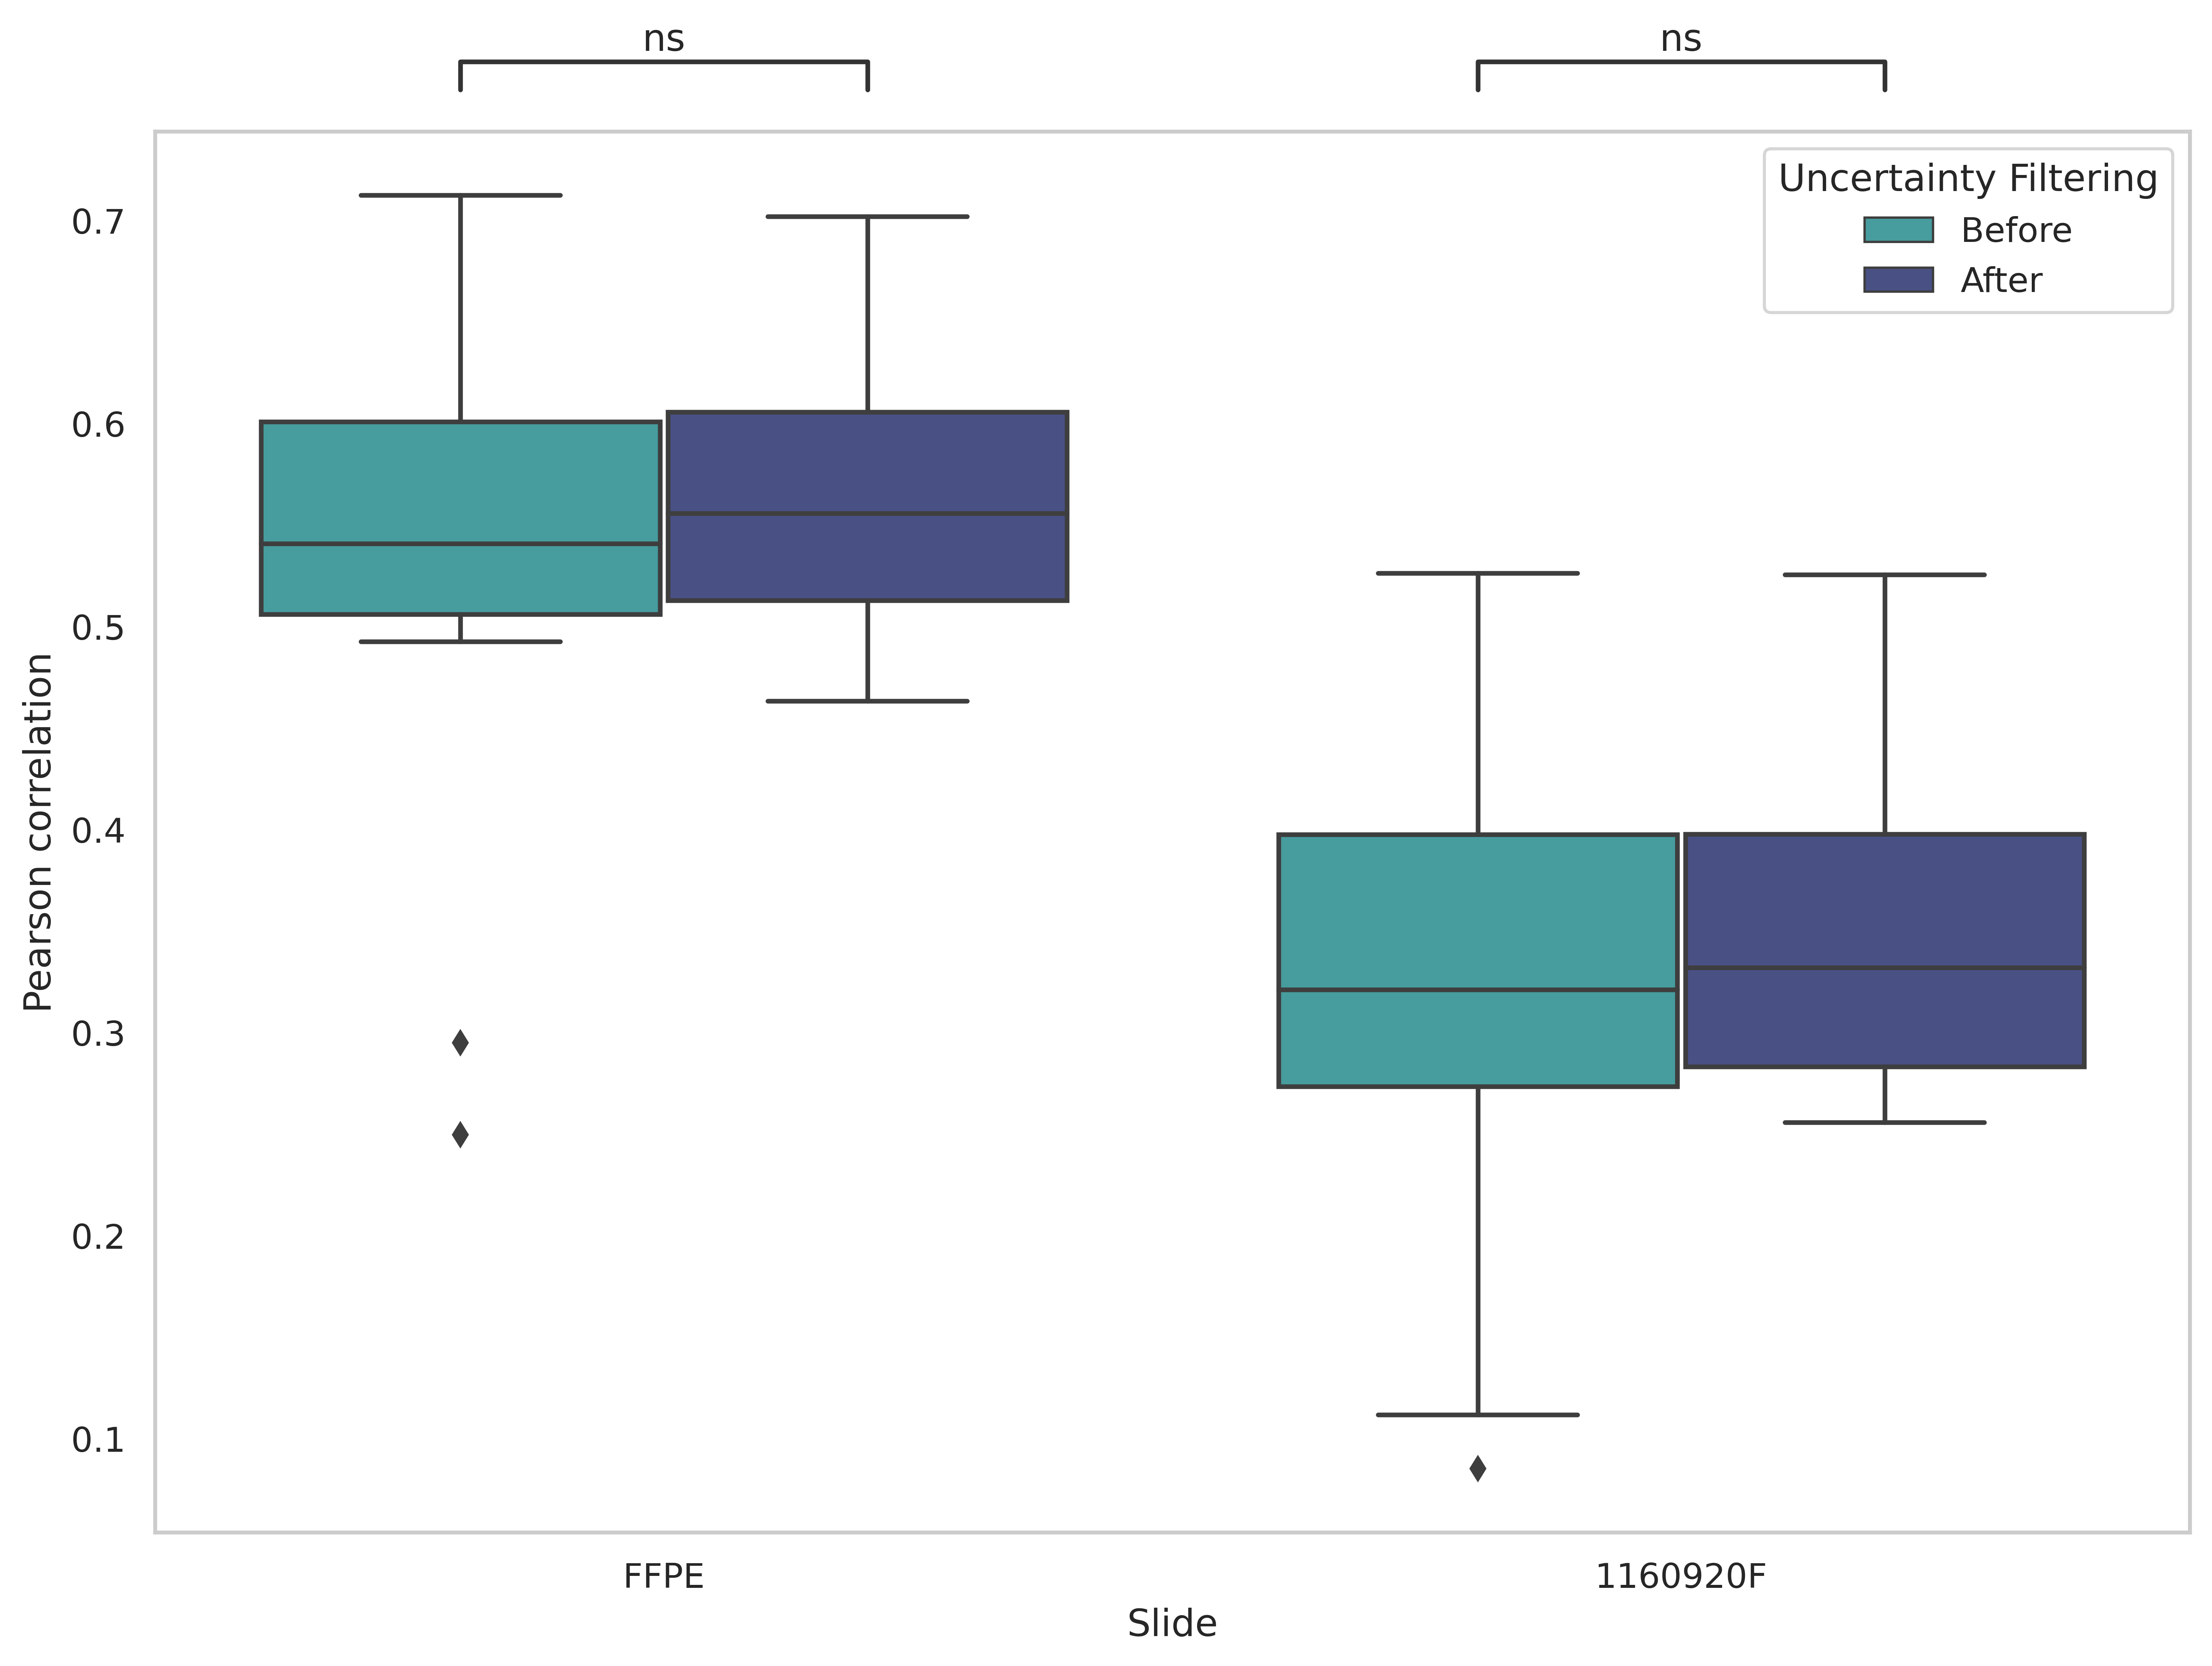

In [58]:
# order = ["FFPE", "1160920F"]
# pairs = [("Before", "After")]
hue = "Uncertainty Filtering"
hue_order=["Before", "After"]
pairs = [(("FFPE", "Before"), ("FFPE", "After")),
         (("1160920F", "Before"), ("1160920F", "After"))]
order = ["FFPE", "1160920F"]
ax = sns.boxplot(
    data=df,
    x="Slide", y="Pearson correlation", palette="mako_r", hue="Uncertainty Filtering", order=order
)
annotator = Annotator(ax, pairs, data=df, x="Slide", y="Pearson correlation",order=order,hue=hue, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()


plt.show()